In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650'

In [3]:
print(torch.__version__, DEVICE)

1.12.0 cuda


In [28]:
BATCH_SIZE = 64
EPOCHS = 100

In [12]:
train_dataset = datasets.MNIST(root='../../data/MNIST/',
                            download=True,
                            train=True,
                            transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='../../data/MNIST/',
                            download=True,
                            train=False,
                            transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE)
test_loader= torch.utils.data.DataLoader(test_dataset,
                                        shuffle=False,
                                        batch_size = BATCH_SIZE)

In [13]:
for (X_train, y_train) in train_loader:
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.FloatTensor torch.LongTensor


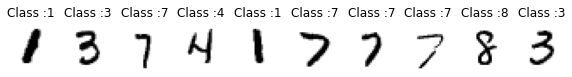

In [14]:
pltsize = 1
plt.figure(figsize=(pltsize*10, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class :' + str(y_train[i].item()))

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [43]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [44]:
def train(model, train_loader, optimizer, log_intervals=100):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0:
            print(f'Train_Epoch: {Epoch}, [{batch_idx * len(image)} / {len(train_loader.dataset)}({(100. * batch_idx / len(train_loader)):.0f}%)\tTrain_Loss ; {(loss.item()):.6f}')

In [45]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [46]:
best_accuracy = 0
es = 0
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        best_model = model
    else :
        es += 1
    # EarlyStopping
    if es == 30:
        break
    print(f'\n[EPOCH: {Epoch}, \tTest_loss : {(test_loss):.4f}, \tTest_accuracy : {(test_accuracy):.2f}%\n') 

C:\Users\Admin\AppData\Local\Temp\ipykernel_22012\1230561995.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train_Epoch: 1, [0 / 60000(0%)	Train_Loss ; 2.307507
Train_Epoch: 1, [6400 / 60000(11%)	Train_Loss ; 0.223581
Train_Epoch: 1, [12800 / 60000(21%)	Train_Loss ; 0.308820
Train_Epoch: 1, [19200 / 60000(32%)	Train_Loss ; 0.136952
Train_Epoch: 1, [25600 / 60000(43%)	Train_Loss ; 0.075029
Train_Epoch: 1, [32000 / 60000(53%)	Train_Loss ; 0.261870
Train_Epoch: 1, [38400 / 60000(64%)	Train_Loss ; 0.086418
Train_Epoch: 1, [44800 / 60000(75%)	Train_Loss ; 0.390152
Train_Epoch: 1, [51200 / 60000(85%)	Train_Loss ; 0.307182
Train_Epoch: 1, [57600 / 60000(96%)	Train_Loss ; 0.076920

[EPOCH: 1, 	Test_loss : 0.0004, 	Test_accuracy : 95.57%

Train_Epoch: 2, [0 / 60000(0%)	Train_Loss ; 0.176903
Train_Epoch: 2, [6400 / 60000(11%)	Train_Loss ; 0.119097
Train_Epoch: 2, [12800 / 60000(21%)	Train_Loss ; 0.079885
Train_Epoch: 2, [19200 / 60000(32%)	Train_Loss ; 0.232722
Train_Epoch: 2, [25600 / 60000(43%)	Train_Loss ; 0.252016
Train_Epoch: 2, [32000 / 60000(53%)	Train_Loss ; 0.121201
Train_Epoch: 2, [38400 / 6

In [47]:
print(best_accuracy)

97.27


In [41]:
del model